# Jane Street Prediction Competition with Fastai+PCA+XGBOOST


> Jane Street Prediction Competition with Fastai+PCA+XGB 


- toc: true 
- badges: true
- comments: true
- description: Kaggle Jane Street Prediction Competition with Fastai + PCA and XGBOOST 
- author: Frederick Emile Bondzie-Arthur
- categories: [fastai, kaggle]

This notebook ocntains my solution (submission not made yet due some challenges with my submission pipeline) to the [Kaggle's Jane Prediction Challenge](https://www.kaggle.com/c/jane-street-market-prediction). 

## Introduction 

Jane Street Market Prediction is a competition organized by kaggle, which you build a model to predict financial market. This competition is a classification competition with the goal to predict an action of class 0 or 1.  

More about the competition can be found in the link above.

### Why THIS Competition
Currently, I am Reading Jeremy Howard and Sylvain Gugger's  Deep Learning for Coders with Fastai and Pytorch book and to understand more about using NN to solve tabular challenges, I entered this challenge. 

Further, the rules of the competition that caught my attention, as your model is passed through 1M test dataset in 5 hours. This means your model should be optimzed, efficient and fast. 

### My Goal:
My major goal in 2021 is to solve more data science problem and also ship codes in production and I believe participating in kaggle challenges will help me achieve that. 


To to waste your time let start. 

## Installing libraries and downloading Datasets 

In [1]:
%%capture
# installing libaries 
!pip install fastai==2.1.2 
!pip install --upgrade fastai 
!pip install nbdev 

!pip install numba 
!pip install optuna 
!pip install xgboost
!pip install kaggle 

import sys
from fastai.tabular.all import * 


In [2]:
import joblib

import numpy as np 
import numpy.ma as ma
from numba import njit

import seaborn as sns
import matplotlib
matplotlib.rc('image', cmap='Greys')
from IPython.display import Image, display_svg, SVG


import time
from tqdm.notebook import tqdm

#import cudf # install cudf on google colab before running this. 
import pandas as pd 
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
pd.options.display.max_rows = 20
pd.options.display.max_columns = 8


from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.inspection import plot_partial_dependence
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import xgboost as xgb 
import optuna 

from fastai.tabular.all import *
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import torch 

## Downloading datasets from Kagggle. 

Before running this make sure you have registered for kaggle, accepted the competition rules and also generated a key to access kaggle's API. 

In [ ]:
# xxx with your kaggle credentials kaggle credentials 
creds = '{"username":"xxxxxxxx","key":"xxxxxxxxxxxxx"}'

In [ ]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser() 
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds) 
    cred_path.chmod(0o600)

In [ ]:
from kaggle import api


In [ ]:
path = URLs.path('jane_street_prediction')
print(path)
Path.BASE_PATH = path 

In [ ]:
# downloading datasets 
if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli('jane-street-market-prediction',path=path)
    file_extract(path/'jane-street-market-prediction.zip')

path.ls(file_type='text')

In [ ]:
!rm -rf /root/.fastai/archive/jane_street_prediction/jane-street-market-prediction.zip

## Loading Data and Preprocessing

In [11]:
# uncomment if you have installed cudf. 
"""
%%time
train_cudf  = cudf.read_csv(path/'train.csv', nrows=250000)
df = train_cudf.to_pandas()
del train_cudf
features = pd.read_csv(path/'features.csv')
example_test = pd.read_csv(path/'example_test.csv')
sample_prediction_df = pd.read_csv(path/'example_sample_submission.csv')
print ("Data is loaded!")
"""

'\n%%time\ntrain_cudf  = cudf.read_csv(path/\'train.csv\', nrows=250000)\ndf = train_cudf.to_pandas()\ndel train_cudf\nfeatures = pd.read_csv(path/\'features.csv\')\nexample_test = pd.read_csv(path/\'example_test.csv\')\nsample_prediction_df = pd.read_csv(path/\'example_sample_submission.csv\')\nprint ("Data is loaded!")\n'

In [ ]:
# Due to memory issue, we load a subset of the dataset. 
df  = pd.read_csv(path/'train.csv', nrows=200000)
features = pd.read_csv(path/'features.csv')
example_test = pd.read_csv(path/'example_test.csv')
sample_prediction_df = pd.read_csv(path/'example_sample_submission.csv')


In [5]:
print('train shape is {}'.format(df.shape))
print('features shape is {}'.format(features.shape))
print('example_test shape is {}'.format(example_test.shape))
print('sample_prediction_df shape is {}'.format(sample_prediction_df.shape))

train shape is (200000, 138)


In [6]:
#  Loading Dataset 
df.head()

,date,weight,resp_1,resp_2,...,feature_127,feature_128,feature_129,ts_id
0,0,0.000000,0.009916,0.014079,...,12.600292,2.301488,11.445807,0
1,0,16.673515,-0.002828,-0.003226,...,2.297459,-1.304614,1.898684,1
2,0,0.000000,0.025134,0.027607,...,10.060014,6.638248,9.427299,2
3,0,0.000000,-0.004730,-0.003273,...,1.266037,3.856384,1.013469,3
4,0,0.138531,0.001252,0.002165,...,5.233243,0.362636,3.926633,4


In [7]:
# trade with weights 0 have action 0, thus we remove all rows with weights 0/ 
df = df[df['weight'] != 0].reset_index(drop = True) 


In [8]:
# setting target dataset, which is action. 
dep_var = 'action'
df[dep_var] = (((df['resp']* df['weight'])>0)*1).astype('category')

In [9]:
# removing all columns starting with resp (i.e. response) since this is not in the final validation datasets. 
df = df.loc[:, ~df.columns.str.contains('resp')]

In [10]:
# extracting all feature columns which we will use for prediction
features_one = [col for col in list(df.columns) if 'feature' in col]
features_nn = features_one + [dep_var]

len(features_one), len(features_nn)

(130, 131)

Due to the nature of the competition, the code below was not executed in my final submission as it decreased the number of iterations/sec.
Ideally, the number of iterations/sec should be about 50-60. However the code below when included in the final run, reduces the number of iterations/sec to 7 (maximum). 

Also, it is important to note that the accuray of our model slightly increases when applied. 

In [11]:
def augment_df(df, features):
    for feature in features:
        df[f'{feature}_sq'] = np.square(df[feature].to_numpy())
        #df[f'{feature}_log'] = df[feature].apply(lambda x: 0 if x==0 else np.log(x))
        df[f'{feature}_log'] = ma.log(df[feature].to_numpy())
        
    df['feature_min'] = df[features].min(axis=1)
    df['feature_mean'] = df[features].mean(axis=1)
    df['feature_max'] = df[features].max(axis=1)
    df['feature_median'] = df[features].median(axis=1)
    df['feature_std'] = df[features].std(axis=1)
    df['feature_var'] = df[features].var(axis=1)
    df['feature_abs_mean'] = df[features].abs().mean(axis=1)
    df['feature_abs_median'] = df[features].abs().median(axis=1)
    df['feature_abs_std'] = df[features].abs().std(axis=1)
    df['feature_skew'] = df[features].skew(axis=1)
    df['feature_kurt'] = df[features].kurt(axis=1)
    df['feature_sq_kurt'] = np.square(df[features_one].kurt(axis=1))
    return df

In [12]:
%time df = augment_df(df, features_one)

CPU times: user 6.07 s, sys: 445 ms, total: 6.51 s
Wall time: 6.53 s


In [13]:
features_nn =  [col for col in list(df.columns) if 'feature' in col] + [dep_var] 
feature_nn_test = [col for col in list(df.columns) if 'feature' in col]


len(feature_nn_test), len(features_nn)

(402, 403)

In [15]:
df.shape

(155528, 406)

In [16]:
df_median = df.median()


# replacing missing values. 
df = df.fillna(df_median)

In [17]:
df.isnull().sum().sum()

0

In [18]:
df[feature_nn_test].astype('float32')
df[dep_var].astype('int')

0         0
1         0
2         1
3         1
4         0
         ..
155523    1
155524    1
155525    1
155526    1
155527    1
Name: action, Length: 155528, dtype: int64

### utility function.

In [19]:

# getting continous and categorical variables from dataset 
def cont_cat_split(df, max_card=20, dep_var=None):
    "Helper function that returns column names of cont and cat variables from given `df`."
    cont_names, cat_names = [], []
    for label in df:
        if label in L(dep_var): continue
        if (pd.api.types.is_integer_dtype(df[label].dtype) and
            df[label].unique().shape[0] > max_card or
            pd.api.types.is_float_dtype(df[label].dtype)):
            cont_names.append(label)
        else: cat_names.append(label)
    return cont_names, cat_names


cont_nn,cat_nn = cont_cat_split(df.loc[:,features_nn], max_card=9000, dep_var=dep_var)

In [20]:
# utility function. Some were used others were not 
def create_train_ds(df, cat, cont, y_name, splits):
    splits = RandomSplitter(valid_pct=0.1)(range_of(df))
    procs  = [Categorify, FillMissing, Normalize] 
    to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
    
    xs, y = to.train.xs.astype(np.float32), to.train.y.astype(np.float32)
    valid_xs,valid_y = to.valid.xs.astype(np.float32),to.valid.y.astype(np.float32)
    
    print(f"length of train {len(to.train)} and legnth of valid {len(to.valid)}")
    
    return to, xs, valid_xs, y, valid_y



def m_accuracy(m, xs, y):
    return accuracy_score(y.values, m.predict(xs))



def _feature_importance(m, df):
    return pd.DataFrame({'cols':df.columns,'imp':m.feature_importances_}).sort_values('imp',
                                                                                     ascending=False)



def plot_feature_importance(fi):
    return fi.plot('cols','imp', 'barh', figsize=(15,15), legend=False)


def roc_auc(m, xs, valid_xs, y, valid_y):
    y_proba = m.predict_proba(valid_xs)
    roc_auc = roc_auc_score(valid_y,m.predict(valid_xs))
    fpr, tpr, thresholds = roc_curve(valid_y, y_proba[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='(area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [21]:
# We impute the missing values with the medians
from numba import njit

@njit
def fillna_npwhere(array, values):
    if np.isnan(array.sum()):
        array = np.where(np.isnan(array), values, array)
    return array



# We impute the missing values with the medians
def fill_nan(test_values, features):
    na_arr=np.ones((1,len(feature_nn_test)), dtype=np.float32)
    na_arr=na_arr*(999)
    xar = test_values - na_arr
    #xar = np.nan_to_num(xar, nan=-999)
    xar = fillna_npwhere(xar, -999)
    xar = xar + na_arr
    test_df = torch.FloatTensor(xar)
    return test_df


## NN using Fastai and using output of model as input to another model.


In this section, we could have Fastai's TabularPandas function but due to some bugs I encounter (still encountering more), I created custom dataloarders for the task. 

In [22]:
splits = RandomSplitter(valid_pct=0.1)(range_of(df))

In [24]:
# splitting dataset into train and test dataset. 
xs, valid_xs = df.loc[splits[0], feature_nn_test], df.loc[splits[1], feature_nn_test]
y, valid_y = df.loc[splits[0], dep_var], df.loc[splits[1], dep_var]

In [25]:
# creating a custom data loaders. 
class Fastai_dls():
    def __init__(self, df, cats=None, y=None):
        df = df.copy() 
        
        if cats is not None:
            self.dfcats = df[cats] 
            self.cats = np.stack([c.values for n, c in self.dfcats.items()], axis=1).astype(np.long)
            self.dfconts = df.drop(cats, axis=1)
            self.conts = np.stack([c.values for n, c in self.dfconts.items()], axis=1).astype(np.float32)
        else:
            self.dfconts = df.copy() 
            self.conts = np.stack([c.values for n, c in self.dfconts.items()], axis=1).astype(np.float32) 
            self.cats = np.zeros(len(df),).astype(np.long)
        
        self.y = y.values
    
    def __len__(self):
        return len(self.y) 
    
    def __getitem__(self, idx):
        return [self.cats[idx], self.conts[idx], self.y[idx]]        

In [26]:
train_ds = Fastai_dls(df=xs, y=y)
valid_ds = Fastai_dls(df=valid_xs, y=valid_y)

In [27]:
train_dl = DataLoader(train_ds, batch_size = 4096, drop_last=True, shuffle=False)
valid_dl = DataLoader(valid_ds, batch_size = 2048, drop_last=True, shuffle=False)

dls = DataLoaders(train_dl, valid_dl, device='cuda')

In [28]:
dls.cats.shape, dls.conts.shape, dls.y.shape

((139976,), (139976, 402), (139976,))

In [29]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [30]:
# defining loss function, metrics and callbacks
loss_func = CrossEntropyLossFlat()
roc_auc = RocAucBinary()

cbs = [GradientAccumulation(),
       EarlyStoppingCallback(monitor='accuracy', comp=np.greater, min_delta=0.01, patience=4), 
       SaveModelCallback(monitor='accuracy', comp=np.greater, min_delta=0.01),
       ReduceLROnPlateau(monitor='accuracy', comp=np.greater, min_delta=0.01, patience=2)]

In [31]:
# defining my model 
class JaneStreet(Module):
    def __init__(self):
        dropout_rate = 0.2
        hidden_size = 256
        n = len(feature_nn_test)
        self.batch_norm0 = nn.BatchNorm1d(n)
        self.dropout0 = nn.Dropout(dropout_rate)

        self.dense1 = nn.Linear(n, hidden_size)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.dense2 = nn.Linear(hidden_size + n, hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.dense3 = nn.Linear(hidden_size + hidden_size, hidden_size)
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(dropout_rate)

        self.dense4 = nn.Linear(hidden_size + hidden_size, hidden_size)
        self.batch_norm4 = nn.BatchNorm1d(hidden_size)
        self.dropout4 = nn.Dropout(dropout_rate)

        self.dense5 = nn.Linear(hidden_size+hidden_size, 2)

      
        self.LeakyReLU = nn.LeakyReLU(negative_slope=0.1, inplace=True)


        self.layers = nn.Sequential(
            nn.BatchNorm1d(n),
            LinBnDrop(n, 400, bn=True, p=0, act=Mish(), lin_first=False),
            LinBnDrop(400, 800, bn=True, p=0.2289, act=Mish(), lin_first=False),   
            LinBnDrop(800, 400, bn=True, p=0.2289, act=Mish(), lin_first=False),
            LinBnDrop(400, n, bn=False, act=None, lin_first=False),) 
    
    def forward(self, cat,x):
        x = self.layers(x)

        x = self.batch_norm0(x)
        x = self.dropout0(x)

        x1 = self.dense1(x) 
        x1 = self.batch_norm1(x1)
        x1 = self.LeakyReLU(x1)
        x1 = self.dropout1(x1)

        x = torch.cat([x, x1], 1)

        x2 = self.dense2(x)
        x2 = self.batch_norm2(x2)

        x2 = self.LeakyReLU(x2)
        x2 = self.dropout2(x2)

        x = torch.cat([x1, x2], 1)

        #x3 = self.dense3(x)
        #x3 = self.batch_norm3(x3)
        #x3 = self.LeakyReLU(x3)
        #x3 = self.dropout3(x3)

       # x = torch.cat([x2, x3], 1)

        #x4 = self.dense4(x)
        #x4 = self.batch_norm4(x4)
        #x4 = self.LeakyReLU(x4)
        #x4 = self.dropout4(x4)

       # x = torch.cat([x3, x4], 1)

        x = self.dense5(x)

        return F.softmax(x, dim=1)
    

model_nn = JaneStreet()
model_nn = model_nn.to(device)

In [32]:
# defining Learner for training 
learn = Learner(dls, model_nn, loss_func = loss_func, metrics=[accuracy,roc_auc]).to_fp32()

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.010964781977236271)

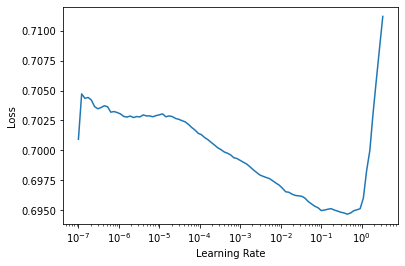

In [33]:
learn.lr_find()

In [34]:
learn.fit_one_cycle(20, 1e-2, cbs=cbs)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.691607,0.684890,0.540806,0.560280,00:02
1,0.685817,0.685720,0.550293,0.573549,00:03
2,0.681287,0.678165,0.560826,0.594965,00:03
3,0.676755,0.673536,0.568429,0.605073,00:03
4,0.671056,0.670174,0.576521,0.617103,00:02
5,0.664675,0.673411,0.559849,0.599095,00:03
6,0.658145,0.668097,0.586147,0.633828,00:02
7,0.650803,0.651233,0.605748,0.659833,00:02
8,0.642964,0.655354,0.606934,0.659029,00:02
9,0.634794,0.650624,0.604771,0.661042,00:02


Better model found at epoch 0 with accuracy value: 0.5408063530921936.
Better model found at epoch 2 with accuracy value: 0.5608258843421936.
Better model found at epoch 4 with accuracy value: 0.5765206217765808.
Epoch 6: reducing lr to 0.0009580172347940181
Better model found at epoch 7 with accuracy value: 0.6057477593421936.
Epoch 9: reducing lr to 0.0007526650921209491
Better model found at epoch 10 with accuracy value: 0.62451171875.
Better model found at epoch 12 with accuracy value: 0.6393694281578064.
Epoch 14: reducing lr to 0.0002526794836121448
Better model found at epoch 15 with accuracy value: 0.6517857313156128.
Epoch 17: reducing lr to 4.449824457047561e-05
No improvement since epoch 15: early stopping


In [35]:
learn.fit_one_cycle(20, 1e-3, wd = 0.0001, cbs=cbs)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.554790,0.627454,0.653878,0.719309,00:02
1,0.552611,0.626815,0.653809,0.722306,00:02
2,0.550028,0.628586,0.651786,0.721557,00:02
3,0.548423,0.628071,0.654018,0.722426,00:03
4,0.546515,0.626714,0.654785,0.724814,00:02


Better model found at epoch 0 with accuracy value: 0.6538783311843872.
Epoch 2: reducing lr to 6.598670704145258e-05
No improvement since epoch 0: early stopping


In [36]:
learn.fit_one_cycle(20,slice(1e-03),wd = 0.0001, cbs=cbs)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.551819,0.627065,0.653878,0.720447,00:02
1,0.550544,0.627526,0.653878,0.722107,00:03
2,0.549451,0.626863,0.654576,0.723404,00:03
3,0.547920,0.626525,0.655622,0.722520,00:02
4,0.546614,0.626699,0.655901,0.722730,00:02


Better model found at epoch 0 with accuracy value: 0.6538783311843872.
Epoch 2: reducing lr to 6.598670704145258e-05
No improvement since epoch 0: early stopping


In [38]:
# running our dataframe to our model and using the output as an input into xGBoost Model 
%time X_test = fill_nan(df.loc[:,features_nn].drop(dep_var, axis=1).values, feature_nn_test).cuda()

CPU times: user 1.26 s, sys: 274 ms, total: 1.54 s
Wall time: 1.57 s


In [39]:
%time preds = learn.model(0, X_test).argmax(dim=1).detach().cpu().numpy()

CPU times: user 133 ms, sys: 93.2 ms, total: 226 ms
Wall time: 227 ms


In [40]:
# adding output as a feature to the df
df['feature_fastai'] = pd.DataFrame(preds)

In [50]:
df.head()

,date,weight,feature_0,feature_1,...,feature_skew,feature_kurt,feature_sq_kurt,feature_fastai
0,0,16.673515,-1,-1.349537,...,0.333055,1.320575,1.743918,0
1,0,0.138531,1,-3.172026,...,0.565369,0.448392,0.201055,1
2,0,0.190575,-1,-3.172026,...,0.587222,0.820025,0.672440,1
3,0,3.820844,-1,0.446050,...,0.435421,0.071277,0.005080,1
4,0,0.116557,1,-3.172026,...,1.260976,3.391439,11.501862,1


In [41]:
df.isnull().sum().sum()

0

In [42]:
features = [col for col in list(df.columns) if 'feature' in col]
len(features)

403

In [53]:
df_median = df.median()

## PCA and Normalization 
Since we did not used fastai's Tabularpandas, we out performed dimension reduction using PCA and also used the StandardScaler to normlize our dataset. 

In [54]:
X = df.loc[:,features]
y =df.loc[:, 'action']

In [55]:
xs, valid_xs, y, valid_y = train_test_split(X, y, test_size=0.1, random_state = 42)

In [56]:
scalar = StandardScaler()
scalar.fit(xs)
xs_norm = scalar.transform(xs)

pca = PCA() 
comp = pca.fit(xs_norm)

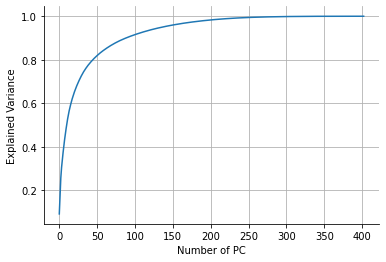

In [57]:
# explained variation in the 403 features. 
plt.plot(np.cumsum(comp.explained_variance_ratio_)) 
plt.grid()
plt.xlabel('Number of PC')
plt.ylabel('Explained Variance')
sns.despine()

In [59]:
# transform training set 
pca = PCA(n_components=175).fit(xs_norm)
xs_transform = pca.transform(xs_norm)

# transform validation set 
valid_xs_transform = pca.transform(scalar.transform(valid_xs))



## Xgboost and Hypertunning

Now that all is set and done. We use optuna for hypertunning to get the best params to run our final model

In [61]:
dtrain = xgb.DMatrix(xs_transform, label=y)
dvalid = xgb.DMatrix(valid_xs_transform, label=valid_y)

def objective(trial):
    # parameters for hypertunning 
    params = {'n_estimators': trial.suggest_int('n_estimators',400, 600),
              'max_depth': trial.suggest_int('max_depth', 10, 20),
              'learning_rate': trial.suggest_uniform('learning_rate', 0.01, .1),
              'subsample' : trial.suggest_uniform('subsample', 0.50, 1),
              'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.50, 1),
              'gamma': trial.suggest_int('gamma', 0, 10),
              'tree_method': 'gpu_hist',
              'objective': 'binary:logistic'}
    
    best = xgb.train(params, dtrain) 
    preds = np.rint(best.predict(dvalid))
    
    accuracy = accuracy_score(valid_y, preds)
    
    return accuracy


In [62]:
study = optuna.create_study()
study.optimize(objective,n_trials=15)

[I 2021-01-26 17:21:58,843] A new study created in memory with name: no-name-cef3f5eb-a80c-4775-a9ab-1e89b9c5d961
[I 2021-01-26 17:22:07,762] Trial 0 finished with value: 0.712852825821385 and parameters: {'n_estimators': 432, 'max_depth': 20, 'learning_rate': 0.05316590799747048, 'subsample': 0.6030339348493646, 'colsample_bytree': 0.5041951234556589, 'gamma': 0}. Best is trial 0 with value: 0.712852825821385.
[I 2021-01-26 17:22:18,330] Trial 1 finished with value: 0.7280267472513341 and parameters: {'n_estimators': 495, 'max_depth': 20, 'learning_rate': 0.06994275310474216, 'subsample': 0.7878025178834351, 'colsample_bytree': 0.8803972779006508, 'gamma': 7}. Best is trial 0 with value: 0.712852825821385.
[I 2021-01-26 17:22:21,231] Trial 2 finished with value: 0.7388285218285862 and parameters: {'n_estimators': 575, 'max_depth': 12, 'learning_rate': 0.08469370253489612, 'subsample': 0.9542683974475639, 'colsample_bytree': 0.9402130470011565, 'gamma': 5}. Best is trial 0 with value: 

In [63]:
best_params = study.best_trial.params
best_params['tree_method'] = 'gpu_hist'
best_params['objective'] = 'binary:logistic'
best_params['missing'] = -999
best_params['random_state'] = 2020

In [64]:
clf = xgb.XGBClassifier(**best_params)
%time clf.fit(xs_transform, y)

CPU times: user 1min 50s, sys: 28 s, total: 2min 18s
Wall time: 2min 18s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5041951234556589, gamma=0,
              learning_rate=0.05316590799747048, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=-999, n_estimators=432, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=2020,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6030339348493646, tree_method='gpu_hist',
              verbosity=1)

In [65]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [66]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [67]:
m_accuracy(clf, xs_transform, y), m_accuracy(clf, valid_xs_transform, valid_y)

(1.0, 0.7538738507040442)

In [68]:
cm = confusion_matrix(valid_y,  clf.predict(valid_xs_transform))
cm

array([[5519, 2000],
       [1828, 6206]])

In [70]:
del dvalid, dtrain

## kaggle Submission Method

In [ ]:
from tqdm import tqdm
import janestreet
env = janestreet.make_env() # initialize the environment
iter_test = env.iter_test() # an ite-ator which loops over the test set

In [ ]:
for (test_df, pred_df) in tqdm(iter_test):
    wt = test_df.iloc[0].weight
    if (wt == 0):
        pred_df.action = 0
    else:
        test_df = augment_df(test_df, features_one)
        #X_test = fill_nan(test_df).cuda()
        X_test = fill_nan(test_df.values, feature_nn_test).cuda()
        preds = learn.model(0, X_test).argmax(dim=1).detach().cpu().numpy()
        test_df['feature_fastai'] = preds
        pred_df.action = clf.predict(pca.transform(scalar.transform(
            fillna_npwhere(test_df[features].values, df_median[features].values))), validate_features=False)
    env.predict(pred_df)
    

15219it [49:10,  5.16it/s]


## Conclusion

As discussed earlier, I have not submitted yet due to some bugs in my submission pipeline above, and also exchausting my kaggle weekly GPU quota.
Will do that next week. 
For now, I go back to algo and data structures and reading Jeremy's Book 


## Reference:

* https://www.kaggle.com/ahmedelhaddad/fastai-submission-custom-ds
* Collaborative filtering tutorial. (https://docs.fast.ai/tutorial.collab)